In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "DBB"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn006881,MSTREDMWTLYISRRVSNKERETRENNRSGRERERMKIQCDVCAKE...,257,1
1,Achn039341,MDKNCKSTASAISACDFCNQKSAVLYCKADSAKLCLFCDQQVHSAN...,411,1
2,Achn067171,MRTLCDVCESAAAILFCAADEAALCRSCDDKVHMCNKLASRHVRVG...,217,1
3,Achn084001,MKIQCDVCEKAPASVICCADEAALCAKCDIEVHAANKLASKHQRLL...,241,1
4,Achn101441,MFKKNSIKTRYFNLRKCIRFRTSGGGCYESNSETLPDVVGGFCLVE...,365,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
2926,0.006135,0.000000,0.006135,0.010225,0.004090,0.002045,0.0,0.002045,0.004090,0.004090,...,0.002045,0.000000,0.002045,0.0,0.000000,0.002045,0.0,0.002045,0.0,0.000000
913,0.010067,0.003356,0.003356,0.000000,0.000000,0.000000,0.0,0.006711,0.000000,0.006711,...,0.000000,0.000000,0.000000,0.0,0.003356,0.000000,0.0,0.000000,0.0,0.000000
2975,0.002778,0.000000,0.002778,0.002778,0.002778,0.000000,0.0,0.002778,0.002778,0.000000,...,0.000000,0.005556,0.005556,0.0,0.002778,0.000000,0.0,0.000000,0.0,0.002778
2794,0.008299,0.000000,0.004149,0.000000,0.000000,0.016598,0.0,0.000000,0.000000,0.004149,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2472,0.000000,0.000000,0.000000,0.008065,0.004032,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.004032,0.000000,0.0,0.004032,0.000000,0.0,0.000000,0.0,0.004032


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2620, 441)
X_test: (656, 441)
y_train: (2620,)
y_test: (656,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 20s 631ms/step - accuracy: 0.5156 - loss: 0.6932

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6210 - loss: 0.6837   

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6481 - loss: 0.6772 - val_accuracy: 0.9695 - val_loss: 0.4428


Epoch 2/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.4419

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9685 - loss: 0.2970 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9688 - loss: 0.2868 - val_accuracy: 0.9828 - val_loss: 0.0417


Epoch 3/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9531 - loss: 0.0780

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9815 - loss: 0.0498 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9817 - loss: 0.0496 - val_accuracy: 0.9866 - val_loss: 0.0280


Epoch 4/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0044

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9907 - loss: 0.0266 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9910 - loss: 0.0272 - val_accuracy: 0.9885 - val_loss: 0.0265


Epoch 5/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0163

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9915 - loss: 0.0261 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9915 - loss: 0.0267 - val_accuracy: 0.9885 - val_loss: 0.0283


Epoch 6/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0178

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9853 - loss: 0.0306 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9866 - loss: 0.0298 - val_accuracy: 0.9905 - val_loss: 0.0248


Epoch 7/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.1146

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9893 - loss: 0.0453 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9894 - loss: 0.0423 - val_accuracy: 0.9943 - val_loss: 0.0185


Epoch 8/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0030

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0131 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0139 - val_accuracy: 0.9924 - val_loss: 0.0239


Epoch 9/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0053

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0111 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9977 - loss: 0.0112 - val_accuracy: 0.9924 - val_loss: 0.0157


Epoch 10/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0020

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0117 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0115 - val_accuracy: 0.9924 - val_loss: 0.0306


Epoch 11/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0071

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0126 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0122 - val_accuracy: 0.9924 - val_loss: 0.0178


Epoch 12/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0028

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0064 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0072 - val_accuracy: 0.9905 - val_loss: 0.0327


Epoch 13/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0121

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0065 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0069 - val_accuracy: 0.9924 - val_loss: 0.0212


Epoch 14/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0013

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0058 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9980 - loss: 0.0057 - val_accuracy: 0.9885 - val_loss: 0.0155


Epoch 15/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 3.6990e-04

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0068     

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0067 - val_accuracy: 0.9847 - val_loss: 0.0378


Epoch 16/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0037

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0039 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0041 - val_accuracy: 0.9828 - val_loss: 0.0544


Epoch 17/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0057

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0075 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0068 - val_accuracy: 0.9905 - val_loss: 0.0226



[Train Accuracy: 99.90% - Test Accuracy: 98.93%]


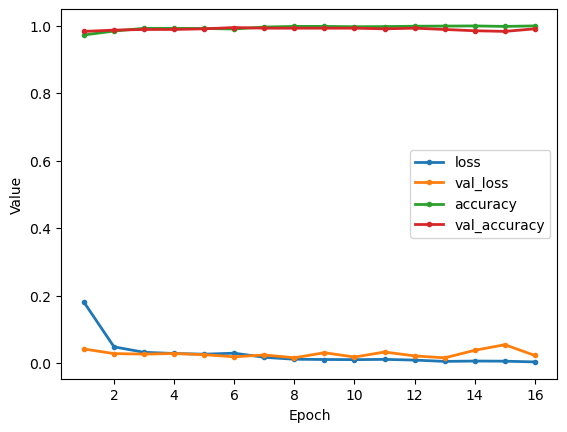

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
2926,0.0,0.0,0.002049,0.0,0.0,0.002049,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
913,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.003367,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2975,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2794,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2472,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.004049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2620, 8585)
X_test: (656, 8585)
y_train: (2620,)
y_test: (656,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,198,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,241,281 (8.55 MB)

 Trainable params: 2,241,281 (8.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 20s 644ms/step - accuracy: 0.4844 - loss: 0.6931

 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5382 - loss: 0.6926   

14/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6020 - loss: 0.6907

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6554 - loss: 0.6872

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7001 - loss: 0.6799

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7222 - loss: 0.6727 - val_accuracy: 0.9637 - val_loss: 0.3837


Epoch 2/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9844 - loss: 0.3753

 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9824 - loss: 0.3333 

16/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9815 - loss: 0.2841

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9826 - loss: 0.2450

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9837 - loss: 0.2160

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9840 - loss: 0.2100 - val_accuracy: 0.9905 - val_loss: 0.0335


Epoch 3/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9844 - loss: 0.1004

 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9947 - loss: 0.0415 

16/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9963 - loss: 0.0292

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9967 - loss: 0.0247

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9967 - loss: 0.0224

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9967 - loss: 0.0219 - val_accuracy: 0.9943 - val_loss: 0.0255


Epoch 4/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9844 - loss: 0.0376

 9/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9951 - loss: 0.0140 

17/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9968 - loss: 0.0104

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9973 - loss: 0.0095

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9973 - loss: 0.0099

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9973 - loss: 0.0099 - val_accuracy: 0.9905 - val_loss: 0.0254


Epoch 5/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 6.8391e-04

 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0016     

16/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0016

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0017

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0018

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 0.0019 - val_accuracy: 0.9924 - val_loss: 0.0459


Epoch 6/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0037

 9/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0048 

17/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 0.0043

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9995 - loss: 0.0038

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9995 - loss: 0.0034

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - loss: 0.0033 - val_accuracy: 0.9924 - val_loss: 0.0266


Epoch 7/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 5.5197e-04

 9/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.2549e-04 

17/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.2278e-04

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.4254e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.4342e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.4340e-04 - val_accuracy: 0.9924 - val_loss: 0.0288


Epoch 8/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 4.3480e-04

 9/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.5039e-04 

17/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.8283e-04

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 5.8857e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 6.7080e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 6.7751e-04 - val_accuracy: 0.9943 - val_loss: 0.0375


Epoch 9/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 7.2577e-04

 9/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.8333e-04 

17/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.4289e-04

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.1037e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7349e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.6932e-04 - val_accuracy: 0.9924 - val_loss: 0.0297


Epoch 10/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.1669e-04

 9/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5716e-04 

17/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1721e-04

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0654e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0889e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.0990e-04 - val_accuracy: 0.9905 - val_loss: 0.0303


Epoch 11/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.5730e-04

 9/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8825e-04 

17/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8810e-04

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8907e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8934e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.8921e-04 - val_accuracy: 0.9924 - val_loss: 0.0310


Epoch 12/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.2373e-04

 9/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2653e-04 

17/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2970e-04

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2934e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2813e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2792e-04 - val_accuracy: 0.9924 - val_loss: 0.0316


Epoch 13/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 4.7563e-05

 9/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.0004e-05 

17/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4497e-04

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7824e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8767e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.8817e-04 - val_accuracy: 0.9943 - val_loss: 0.0344



[Train Accuracy: 100.00% - Test Accuracy: 99.39%]


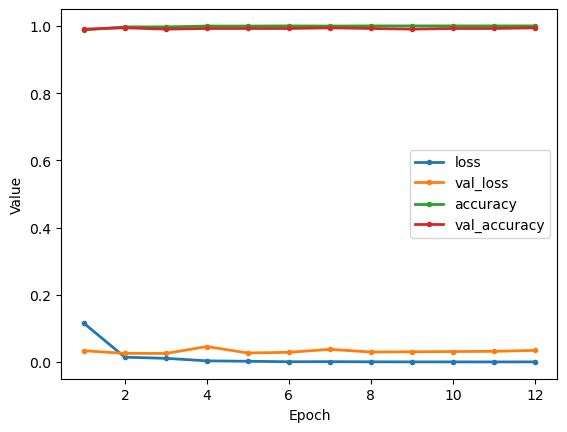

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
2926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      33,022,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,063,937 (126.13 MB)

 Trainable params: 33,063,937 (126.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 27s 855ms/step - accuracy: 0.5000 - loss: 0.6931

 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.5078 - loss: 0.6931  

 3/33 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5174 - loss: 0.6929

 4/33 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5179 - loss: 0.6929

 5/33 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5162 - loss: 0.6929

 6/33 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5174 - loss: 0.6928

 7/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5184 - loss: 0.6927

 8/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5193 - loss: 0.6925

 9/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5189 - loss: 0.6924

10/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5181 - loss: 0.6923

11/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5190 - loss: 0.6921

12/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5199 - loss: 0.6920

13/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.5205 - loss: 0.6918

14/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5205 - loss: 0.6916

15/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5205 - loss: 0.6914

16/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5205 - loss: 0.6911

17/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5209 - loss: 0.6909

18/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5215 - loss: 0.6906

19/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5226 - loss: 0.6903

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5244 - loss: 0.6900

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5268 - loss: 0.6897

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5295 - loss: 0.6893

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5322 - loss: 0.6889

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5351 - loss: 0.6884

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5381 - loss: 0.6880

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5415 - loss: 0.6875

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5451 - loss: 0.6869

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5489 - loss: 0.6864

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5528 - loss: 0.6858

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5568 - loss: 0.6852

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5608 - loss: 0.6845

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5649 - loss: 0.6838

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5690 - loss: 0.6830

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.5728 - loss: 0.6823 - val_accuracy: 0.9885 - val_loss: 0.5356


Epoch 2/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 9s 292ms/step - accuracy: 1.0000 - loss: 0.5388

 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 1.0000 - loss: 0.5301 

 3/33 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 1.0000 - loss: 0.5254

 4/33 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 1.0000 - loss: 0.5205

 5/33 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9994 - loss: 0.5163

 6/33 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9990 - loss: 0.5116

 7/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9989 - loss: 0.5070

 8/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9985 - loss: 0.5022

 9/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9981 - loss: 0.4975

10/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9978 - loss: 0.4927

11/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9971 - loss: 0.4878

12/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9964 - loss: 0.4831

13/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9958 - loss: 0.4782

14/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9954 - loss: 0.4734

15/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9950 - loss: 0.4685

16/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9946 - loss: 0.4636

17/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9942 - loss: 0.4586

18/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9939 - loss: 0.4537

19/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9936 - loss: 0.4488

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9933 - loss: 0.4439

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9931 - loss: 0.4389

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9929 - loss: 0.4339

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9928 - loss: 0.4289

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9927 - loss: 0.4239

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9925 - loss: 0.4191

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9924 - loss: 0.4143

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9922 - loss: 0.4095

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9921 - loss: 0.4048

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9920 - loss: 0.4002

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9918 - loss: 0.3957

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9917 - loss: 0.3912

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9917 - loss: 0.3868

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9916 - loss: 0.3825

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9915 - loss: 0.3785 - val_accuracy: 0.9885 - val_loss: 0.0452


Epoch 3/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 0.0266

 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 1.0000 - loss: 0.0242 

 3/33 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9965 - loss: 0.0271

 4/33 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9954 - loss: 0.0278

 5/33 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.9951 - loss: 0.0277

 6/33 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.9951 - loss: 0.0271

 7/33 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.9951 - loss: 0.0266

 8/33 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9952 - loss: 0.0259

 9/33 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9954 - loss: 0.0254

10/33 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9955 - loss: 0.0249

11/33 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9957 - loss: 0.0244

12/33 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9957 - loss: 0.0243

13/33 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9958 - loss: 0.0242

14/33 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9958 - loss: 0.0240

15/33 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9959 - loss: 0.0238

16/33 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9960 - loss: 0.0236

17/33 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9960 - loss: 0.0233

18/33 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9961 - loss: 0.0231

19/33 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9962 - loss: 0.0228

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9963 - loss: 0.0226

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9963 - loss: 0.0223

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9964 - loss: 0.0221

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9964 - loss: 0.0219

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9965 - loss: 0.0217

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9965 - loss: 0.0215

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9966 - loss: 0.0213

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9966 - loss: 0.0211

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9967 - loss: 0.0209

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9967 - loss: 0.0207

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9967 - loss: 0.0206

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9968 - loss: 0.0204

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9968 - loss: 0.0202

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9968 - loss: 0.0201

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9968 - loss: 0.0199 - val_accuracy: 0.9943 - val_loss: 0.0228


Epoch 4/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 0.0032

 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 1.0000 - loss: 0.0039 

 3/33 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 1.0000 - loss: 0.0041

 4/33 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 1.0000 - loss: 0.0041

 5/33 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 1.0000 - loss: 0.0045

 6/33 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 1.0000 - loss: 0.0046

 7/33 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 1.0000 - loss: 0.0046

 8/33 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0046

 9/33 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0045

10/33 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0045

11/33 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0044

12/33 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0043

13/33 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0042

14/33 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0042

15/33 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9999 - loss: 0.0044

16/33 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9999 - loss: 0.0045

17/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9998 - loss: 0.0046

18/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9998 - loss: 0.0048

19/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9998 - loss: 0.0049

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9997 - loss: 0.0049

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9997 - loss: 0.0050

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9997 - loss: 0.0050

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9997 - loss: 0.0051

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9997 - loss: 0.0051

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9996 - loss: 0.0051

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9996 - loss: 0.0051

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9996 - loss: 0.0051

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9996 - loss: 0.0051

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9996 - loss: 0.0051

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9996 - loss: 0.0051

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9996 - loss: 0.0051

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9996 - loss: 0.0051

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9996 - loss: 0.0051

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.9996 - loss: 0.0051 - val_accuracy: 0.9943 - val_loss: 0.0192


Epoch 5/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 7.8315e-04

 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 1.0000 - loss: 9.0742e-04 

 3/33 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 1.0000 - loss: 9.3541e-04

 4/33 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 1.0000 - loss: 9.4151e-04

 5/33 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 1.0000 - loss: 9.4235e-04

 6/33 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 1.0000 - loss: 9.4101e-04

 7/33 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 1.0000 - loss: 9.4752e-04

 8/33 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 9.5070e-04

 9/33 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 9.4985e-04

10/33 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 9.4640e-04

11/33 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 9.4636e-04

12/33 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 9.4746e-04

13/33 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 9.4890e-04

14/33 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 9.4847e-04

15/33 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 9.4751e-04

16/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 9.4483e-04

17/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 9.4258e-04

18/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 9.4059e-04

19/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 9.5595e-04

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 9.6995e-04

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 9.8137e-04

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 9.9701e-04

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0010    

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0010

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0010

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0010

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0010

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0011

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0011

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0011

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0011

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0011

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0011

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9943 - val_loss: 0.0187


Epoch 6/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 0.0017

 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 1.0000 - loss: 0.0040 

 3/33 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 1.0000 - loss: 0.0041

 4/33 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 1.0000 - loss: 0.0040

 5/33 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 1.0000 - loss: 0.0038

 6/33 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 1.0000 - loss: 0.0036

 7/33 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 1.0000 - loss: 0.0034

 8/33 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 0.0032

 9/33 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0031

10/33 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0030

11/33 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0028

12/33 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0028

13/33 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0027

14/33 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0026

15/33 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0025

16/33 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0025

17/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.0024

18/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.0023

19/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.0023

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0022

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0022

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0021

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0021

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0021

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0020

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0020

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0020

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0020

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0020

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0019

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0019

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0019

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0019

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9943 - val_loss: 0.0187


Epoch 7/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 1.0000 - loss: 6.0086e-04

 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 1.0000 - loss: 7.1134e-04

 3/33 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 7.1227e-04

 4/33 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 6.8857e-04

 5/33 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 6.7066e-04

 6/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 6.5841e-04

 7/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 6.5655e-04

 8/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 6.5274e-04

 9/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 6.4458e-04

10/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 6.3482e-04

11/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 6.2712e-04

12/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 6.1895e-04

13/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 6.1130e-04

14/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 6.0374e-04

15/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 5.9680e-04

16/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 5.8964e-04

17/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 5.8230e-04

18/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 5.7492e-04

19/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 5.6768e-04

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 5.6075e-04

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 5.5413e-04

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 5.4816e-04

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 5.4236e-04

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 5.3665e-04

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 5.3124e-04

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 5.2586e-04

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 5.2068e-04

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 5.1562e-04

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 5.1069e-04

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 5.0607e-04

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 5.0175e-04

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.9986e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 4.9807e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 1.0000 - loss: 4.9638e-04 - val_accuracy: 0.9924 - val_loss: 0.0231


Epoch 8/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 1.0000 - loss: 3.0533e-04

 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 3.1903e-04

 3/33 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 3.0994e-04

 4/33 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 3.0113e-04

 5/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 3.0158e-04

 6/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 2.9722e-04

 7/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.9625e-04

 8/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.9499e-04

 9/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.9460e-04

10/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.9353e-04

11/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.9201e-04

12/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.9042e-04

13/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.8966e-04

14/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.8929e-04

15/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.8903e-04

16/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.8936e-04

17/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.9003e-04

18/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.9095e-04

19/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.9146e-04

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.9168e-04

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.9176e-04

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.9147e-04

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.9134e-04

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.9104e-04

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.9047e-04

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.8981e-04

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.8905e-04

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.8821e-04

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.8743e-04

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.8653e-04

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.8562e-04

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.8522e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.8486e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 1.0000 - loss: 2.8453e-04 - val_accuracy: 0.9924 - val_loss: 0.0223


Epoch 9/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 1.0000 - loss: 1.4319e-04

 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 1.5282e-04

 3/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 1.5539e-04

 4/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 1.6590e-04

 5/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 1.6801e-04

 6/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.6740e-04

 7/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.6723e-04

 8/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.7887e-04

 9/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.8669e-04

10/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.9311e-04

11/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.9832e-04

12/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.0298e-04

13/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.0612e-04

14/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.0810e-04

15/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.0927e-04

16/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.1024e-04

17/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.1123e-04

18/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.1179e-04

19/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.1188e-04

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.1201e-04

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.1193e-04

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.1159e-04

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.1125e-04

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.1077e-04

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.1042e-04

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.0999e-04

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.0946e-04

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.0885e-04

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.0819e-04

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.0749e-04

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.0679e-04

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.0609e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 2.0539e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 1.0000 - loss: 2.0473e-04 - val_accuracy: 0.9924 - val_loss: 0.0249


Epoch 10/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 1.0000 - loss: 1.2337e-04

 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 1.4544e-04

 3/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 1.4450e-04

 4/33 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 1.4129e-04

 5/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 1.5448e-04

 6/33 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 1.6233e-04

 7/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.6587e-04

 8/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.6673e-04

 9/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.6646e-04

10/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.6699e-04

11/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.6648e-04

12/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.6552e-04

13/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.6417e-04

14/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.6299e-04

15/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.6173e-04

16/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.6051e-04

17/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.5964e-04

18/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.5877e-04

19/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.5799e-04

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.5725e-04

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.5651e-04

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.5572e-04

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.5501e-04

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.5438e-04

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.5397e-04

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.5350e-04

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.5297e-04

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.5242e-04

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.5209e-04

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.5174e-04

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.5161e-04

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.5143e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.5122e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 1.0000 - loss: 1.5102e-04 - val_accuracy: 0.9924 - val_loss: 0.0249


Epoch 11/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 1.0000 - loss: 1.5805e-04

 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 1.4379e-04

 3/33 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 1.3544e-04

 4/33 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 1.3729e-04

 5/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 1.3532e-04

 6/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.3531e-04

 7/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.3403e-04

 8/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.3243e-04

 9/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.3159e-04

10/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.3095e-04

11/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.2989e-04

12/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.2878e-04

13/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.2771e-04

14/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.2661e-04

15/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.2729e-04

16/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.2780e-04

17/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.2824e-04

18/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.2842e-04

19/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.2844e-04

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.2836e-04

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.2849e-04

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.2868e-04

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.2871e-04

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.2865e-04

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.2859e-04

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.2844e-04

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.2823e-04

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.2801e-04

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.2794e-04

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.2783e-04

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.2764e-04

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.2750e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.2737e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 1.0000 - loss: 1.2725e-04 - val_accuracy: 0.9924 - val_loss: 0.0240


Epoch 12/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 1.0000 - loss: 7.0063e-05

 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 7.6122e-05

 3/33 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 7.7820e-05

 4/33 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 1.1707e-04

 5/33 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 1.3530e-04

 6/33 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 1.4406e-04

 7/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.4921e-04

 8/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.5286e-04

 9/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.5447e-04

10/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.5461e-04

11/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.5449e-04

12/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.5445e-04

13/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.5408e-04

14/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.5334e-04

15/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.5230e-04

16/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.5141e-04

17/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.5037e-04

18/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.4943e-04

19/33 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.4852e-04

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.4754e-04

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.4660e-04

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.4569e-04

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.4481e-04

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.4387e-04

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.4315e-04

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.4248e-04

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.4174e-04

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.4109e-04

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.4041e-04

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.3977e-04

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.3914e-04

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.3857e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.3800e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 1.0000 - loss: 1.3745e-04 - val_accuracy: 0.9924 - val_loss: 0.0234


Epoch 13/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 1.0000 - loss: 4.7588e-05

 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 7.3374e-05

 3/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 8.1666e-05

 4/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 8.9679e-05

 5/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 9.2700e-05

 6/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 9.5165e-05

 7/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 9.5876e-05

 8/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 9.8276e-05

 9/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 9.9743e-05

10/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.0047e-04

11/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.0053e-04

12/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.0028e-04

13/33 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 9.9898e-05

14/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 9.9314e-05

15/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 9.8620e-05

16/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 9.7859e-05

17/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 9.7289e-05

18/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 9.6628e-05

19/33 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 9.6053e-05

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.5703e-05

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.5324e-05

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.4911e-05

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.4532e-05

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.4296e-05

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.4099e-05

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.3899e-05

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.3721e-05

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.3810e-05

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.3877e-05

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.4010e-05

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.4233e-05

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.4384e-05

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.4536e-05

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 1.0000 - loss: 9.4679e-05 - val_accuracy: 0.9924 - val_loss: 0.0241



[Train Accuracy: 100.00% - Test Accuracy: 98.63%]


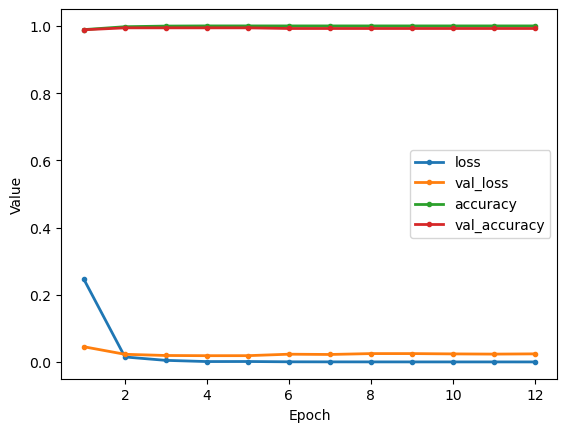

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

 6/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

11/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

16/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

 6/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

11/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

16/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [26]:
report.save()

Report saved as Output/Reports/DBB/report_E9VUYR4V.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################